In [2]:
!pip install backtrader

     |████████████████████████████████| 419kB 2.8MB/s 


In [143]:
import backtrader as bt
import backtrader.indicators as btind
import datetime
import pandas as pd
import pandas_datareader.data as web
from pandas import Series, DataFrame
import random
from copy import deepcopy
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
class SMAC(bt.Strategy):
    """A simple moving average crossover strategy; crossing of a fast and slow moving average generates buy/sell
       signals"""
    params = {"fast": 20, "slow": 50,                  # The windows for both fast and slow moving averages
              "optim": False, "optim_fs": (20, 50)}    # Used for optimization; equivalent of fast and slow, but a tuple
                                                       # The first number in the tuple is the fast MA's window, the
                                                       # second the slow MA's window
 
    def __init__(self):
        """Initialize the strategy"""
 
        self.fastma = dict()
        self.slowma = dict()
        self.regime = dict()
 
        self._addobserver(True, bt.observers.BuySell)    # CAUTION: Abuse of the method, I will change this in future code (see: https://community.backtrader.com/topic/473/plotting-just-the-account-s-value/4)
 
        if self.params.optim:    # Use a tuple during optimization
            self.params.fast, self.params.slow = self.params.optim_fs    # fast and slow replaced by tuple's contents
 
        if self.params.fast > self.params.slow:
            raise ValueError(
                "A SMAC strategy cannot have the fast moving average's window be " + \
                 "greater than the slow moving average window.")
 
        for d in self.getdatanames():
 
            # The moving averages
            self.fastma[d] = btind.SimpleMovingAverage(self.getdatabyname(d),      # The symbol for the moving average
                                                       period=self.params.fast,    # Fast moving average
                                                       plotname="FastMA: " + d)
            self.slowma[d] = btind.SimpleMovingAverage(self.getdatabyname(d),      # The symbol for the moving average
                                                       period=self.params.slow,    # Slow moving average
                                                       plotname="SlowMA: " + d)
 
            # Get the regime
            self.regime[d] = self.fastma[d] - self.slowma[d]    # Positive when bullish
 
    def next(self):
        """Define what will be done in a single step, including creating and closing trades"""
        for d in self.getdatanames():    # Looping through all symbols
            pos = self.getpositionbyname(d).size or 0
            if pos == 0:    # Are we out of the market?
                # Consider the possibility of entrance
                # Notice the indexing; [0] always mens the present bar, and [-1] the bar immediately preceding
                # Thus, the condition below translates to: "If today the regime is bullish (greater than
                # 0) and yesterday the regime was not bullish"
                if self.regime[d][0] > 0 and self.regime[d][-1] <= 0:    # A buy signal
                    self.buy(data=self.getdatabyname(d))
 
            else:    # We have an open position
                if self.regime[d][0] <= 0 and self.regime[d][-1] > 0:    # A sell signal
                    self.sell(data=self.getdatabyname(d))

In [5]:
class PropSizer(bt.Sizer):
    """A position sizer that will buy as many stocks as necessary for a certain proportion of the portfolio
       to be committed to the position, while allowing stocks to be bought in batches (say, 100)"""
    params = {"prop": 0.1, "batch": 100}
 
    def _getsizing(self, comminfo, cash, data, isbuy):
        """Returns the proper sizing"""
 
        if isbuy:    # Buying
            target = self.broker.getvalue() * self.params.prop    # Ideal total value of the position
            price = data.close[0]
            shares_ideal = target / price    # How many shares are needed to get target
            batches = int(shares_ideal / self.params.batch)    # How many batches is this trade?
            shares = batches * self.params.batch    # The actual number of shares bought
 
            if shares * price > cash:
                return 0    # Not enough money for this trade
            else:
                return shares
 
        else:    # Selling
            return self.broker.getposition(data).size    # Clear the position


In [24]:
cerebro = bt.Cerebro(stdstats=False)    # I don't want the default plot objects


In [25]:
cerebro.broker.set_cash(1000000)    # Set our starting cash to $1,000,000
cerebro.broker.setcommission(0.02)

In [26]:
class PandasData(bt.feed.DataBase):
    params = (
        ('datetime', None),
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('openinterest', None),
    )

In [29]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2016, 10, 31)
is_first = True
# Not the same set of symbols as in other blog posts
symbols = ["AAPL", "GOOG", "MSFT", "AMZN", "SNY", "NTDOY", "IBM", "HPQ", "QCOM", "NVDA"]
plot_symbols = ["AAPL", "GOOG", "NVDA"]
#plot_symbols = []
for s in symbols:

    data = web.DataReader(
            name = s,
            data_source = 'yahoo',
            start = '2010-01-01',
            end = '2016-10-31'  
        ).rename(
            columns = {
                'Open': 'open',
                'High': 'high',
                'Low': 'low',
                'Close': 'close',
                'Volume': 'volume'
            }
            
        )


    data = bt.feeds.PandasData(dataname = data, fromdate = start, todate = end)
    if s in plot_symbols:
        if is_first:
            data_main_plot = data
            is_first = False
        else:
            data.plotinfo.plotmaster = data_main_plot
    else:
        data.plotinfo.plot = False
    cerebro.adddata(data, name = s)    # Give the data to cerebro

In [31]:
cerebro.datasbyname

OrderedDict([('AAPL',
              <backtrader.feeds.pandafeed.PandasData at 0x1f808b45dc8>),
             ('GOOG',
              <backtrader.feeds.pandafeed.PandasData at 0x1f808981cc8>),
             ('MSFT',
              <backtrader.feeds.pandafeed.PandasData at 0x1f808a394c8>),
             ('AMZN',
              <backtrader.feeds.pandafeed.PandasData at 0x1f80887fb08>),
             ('SNY', <backtrader.feeds.pandafeed.PandasData at 0x1f808b53ac8>),
             ('NTDOY',
              <backtrader.feeds.pandafeed.PandasData at 0x1f8089c4708>),
             ('IBM', <backtrader.feeds.pandafeed.PandasData at 0x1f8088882c8>),
             ('HPQ', <backtrader.feeds.pandafeed.PandasData at 0x1f80891b0c8>),
             ('QCOM',
              <backtrader.feeds.pandafeed.PandasData at 0x1f8080d14c8>),
             ('NVDA',
              <backtrader.feeds.pandafeed.PandasData at 0x1f808976988>)])

In [32]:
class AcctValue(bt.Observer):
    alias = ('Value',)
    lines = ('value',)
 
    plotinfo = {"plot": True, "subplot": True}
 
    def next(self):
        self.lines.value[0] = self._owner.broker.getvalue()    # Get today's account value (cash + stocks)


In [33]:
cerebro.addobserver(AcctValue)
cerebro.addstrategy(SMAC)
cerebro.addsizer(PropSizer)

In [34]:
cerebro.broker.getvalue()

1000000

In [35]:
%time cerebro.run()

Wall time: 6.29 s


<IPython.core.display.Javascript object>


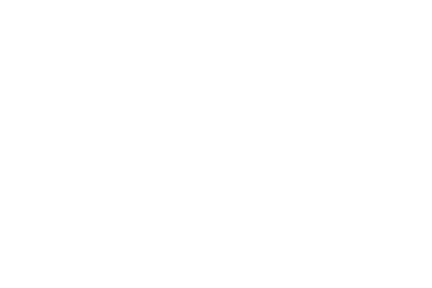

[[<Figure size 432x288 with 4 Axes>]]

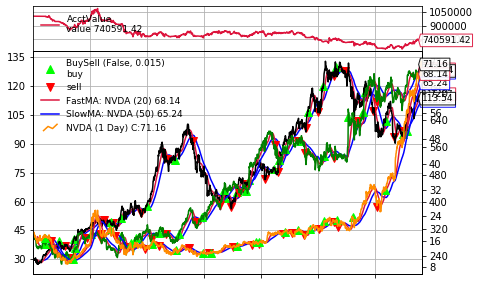

In [137]:
cerebro.plot()

In [37]:
cerebro.broker.getvalue()

740591.4180202484

In [41]:
class AcctStats(bt.Analyzer):
    """A simple analyzer that gets the gain in the value of the account; should be self-explanatory"""
 
    def __init__(self):
        self.start_val = self.strategy.broker.get_value()
        self.end_val = None
 
    def stop(self):
        self.end_val = self.strategy.broker.get_value()
 
    def get_analysis(self):
        return {"start": self.start_val, "end": self.end_val,
                "growth": self.end_val - self.start_val, "return": self.end_val / self.start_val}

In [42]:
# Generate random combinations of fast and slow window lengths to test
windowset = set()    # Use a set to avoid duplicates
while len(windowset) < 40:
    f = random.randint(1, 10) * 5
    s = random.randint(1, 10) * 10
    if f > s:    # Cannot have the fast moving average have a longer window than the slow, so swap
        f, s = s, f
    elif f == s:    # Cannot be equal, so do nothing, discarding results
        pass
    windowset.add((f, s))
 
windows = list(windowset)
windows

[(20, 25),
 (15, 20),
 (50, 100),
 (45, 80),
 (30, 60),
 (50, 60),
 (15, 50),
 (20, 100),
 (30, 70),
 (10, 100),
 (5, 80),
 (10, 80),
 (25, 70),
 (35, 40),
 (15, 70),
 (35, 50),
 (20, 40),
 (30, 100),
 (5, 60),
 (15, 80),
 (40, 90),
 (25, 60),
 (20, 80),
 (10, 40),
 (30, 90),
 (10, 70),
 (10, 50),
 (15, 60),
 (15, 100),
 (20, 50),
 (20, 90),
 (30, 40),
 (10, 25),
 (50, 90),
 (5, 20),
 (15, 40),
 (10, 20),
 (40, 50),
 (30, 30),
 (30, 50)]

In [52]:
optorebro = bt.Cerebro(maxcpus=1)    # Object for optimization (setting maxcpus to 1
                                     # cuz parallelization throws errors; why?)
optorebro.broker.set_cash(1000000)
optorebro.broker.setcommission(0.02)
optorebro.optstrategy(SMAC, optim=True,    # Optimize the strategy (use optim variant of SMAC)...
                      optim_fs=windows)    # ... over all possible combinations of windows

In [53]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2016, 10, 31)
is_first = True
# Not the same set of symbols as in other blog posts
symbols = ["AAPL", "GOOG", "MSFT", "AMZN", "SNY", "NTDOY", "IBM", "HPQ", "QCOM", "NVDA"]
plot_symbols = ["AAPL", "GOOG", "NVDA"]
#plot_symbols = []
for s in symbols:

    data = web.DataReader(
            name = s,
            data_source = 'yahoo',
            start = '2010-01-01',
            end = '2016-10-31'  
        ).rename(
            columns = {
                'Open': 'open',
                'High': 'high',
                'Low': 'low',
                'Close': 'close',
                'Volume': 'volume'
            }
            
        )


    data = bt.feeds.PandasData(dataname = data, fromdate = start, todate = end)
    if s in plot_symbols:
        if is_first:
            data_main_plot = data
            is_first = False
        else:
            data.plotinfo.plotmaster = data_main_plot
    else:
        data.plotinfo.plot = False
    optorebro.adddata(data, name = s)    # Give the data to cerebro

In [54]:
optorebro.addanalyzer(AcctStats)
optorebro.addsizer(PropSizer)

In [55]:
%time res = optorebro.run()    # Perform the optimization

Wall time: 4min 23s


In [61]:
# Store results of optimization in a DataFrame
return_opt = DataFrame({r[0].params.optim_fs: r[0].analyzers.acctstats.get_analysis() for r in res}
                      ).T.loc[:, ['end', 'growth', 'return']]

In [62]:
return_opt.sort_values("growth", ascending=False)

,,end,growth,return
20,100,1.161962e+06,161961.513071,1.161962
30,100,1.146747e+06,146746.859003,1.146747
15,100,1.145166e+06,145166.024206,1.145166
50,100,1.143619e+06,143619.028183,1.143619
20,90,1.141758e+06,141757.596916,1.141758
30,90,1.106860e+06,106860.493858,1.106860
20,80,1.102236e+06,102235.540721,1.102236
15,80,1.086937e+06,86937.209839,1.086937
50,90,1.082011e+06,82010.783635,1.082011
30,70,1.042426e+06,42425.663196,1.042426


In [57]:
fast_opt, slow_opt = return_opt.sort_values("growth", ascending=False).iloc[0].name
 
cerebro_opt = bt.Cerebro(stdstats=False)
cerebro_opt.broker.set_cash(1000000)
cerebro_opt.broker.setcommission(0.02)
cerebro_opt.addobserver(AcctValue)
cerebro_opt.addstrategy(SMAC, fast=fast_opt, slow=slow_opt)
cerebro_opt.addsizer(PropSizer)
 
cerebro_test = deepcopy(cerebro_opt)

In [58]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2016, 10, 31)
is_first = True
# Not the same set of symbols as in other blog posts
symbols = ["AAPL", "GOOG", "MSFT", "AMZN", "SNY", "NTDOY", "IBM", "HPQ", "QCOM", "NVDA"]
plot_symbols = ["AAPL", "GOOG", "NVDA"]
#plot_symbols = []
for s in symbols:

    data = web.DataReader(
            name = s,
            data_source = 'yahoo',
            start = '2010-01-01',
            end = '2016-10-31'  
        ).rename(
            columns = {
                'Open': 'open',
                'High': 'high',
                'Low': 'low',
                'Close': 'close',
                'Volume': 'volume'
            }
            
        )


    data = bt.feeds.PandasData(dataname = data, fromdate = start, todate = end)
    if s in plot_symbols:
        if is_first:
            data_main_plot = data
            is_first = False
        else:
            data.plotinfo.plotmaster = data_main_plot
    else:
        data.plotinfo.plot = False
    cerebro_opt.adddata(data, name = s)    # Give the data to cerebro

In [59]:
%time cerebro_opt.run()

Wall time: 6.74 s


In [60]:
cerebro_opt.broker.get_value()

1161961.5130710602

In [83]:
import numpy as np

In [118]:
close_df = pd.DataFrame()

for dataname in cerebro_opt.datasbyname.keys():
    data = cerebro_opt.datasbyname[dataname]
    close_prices = list()
    for i in np.arange(0, -100, -1):
        close_prices.append(data.close[i])
    prices = pd.Series(close_prices)
    close_df[dataname] = prices
close_df

,AAPL,GOOG,MSFT,AMZN,SNY,NTDOY,IBM,HPQ,QCOM,NVDA
0,113.540001,784.539978,59.919998,789.820007,38.889999,30.090000,153.690002,14.49,68.720001,71.160004
1,113.720001,795.369995,59.869999,776.320007,38.840000,30.170000,152.610001,14.09,68.400002,70.559998
2,114.480003,795.349976,60.099998,818.359985,37.250000,29.650000,153.350006,13.99,70.089996,70.680000
3,115.589996,799.070007,60.630001,822.590027,37.060001,28.030001,151.809998,13.91,68.199997,72.160004
4,118.250000,807.669983,60.990002,835.179993,37.389999,29.580000,150.880005,13.90,67.709999,71.870003
...,...,...,...,...,...,...,...,...,...,...
95,97.550003,710.359985,50.389999,717.510010,38.400002,17.670000,151.059998,12.98,53.419998,47.549999
96,97.139999,718.919983,49.689999,714.260010,38.169998,17.780001,150.679993,13.00,53.279999,47.360001
97,97.459999,718.270020,49.830002,719.299988,38.130001,17.820000,151.059998,13.05,52.700001,46.880001
98,97.339996,718.359985,50.139999,715.239990,39.000000,18.010000,151.279999,13.03,52.830002,46.790001


In [119]:
from sklearn.decomposition import PCA

In [120]:
pca = PCA(n_components = 1)
pca.fit(close_df)

PCA(n_components=1)

In [123]:
pca.explained_variance_ratio_

array([0.90457891])

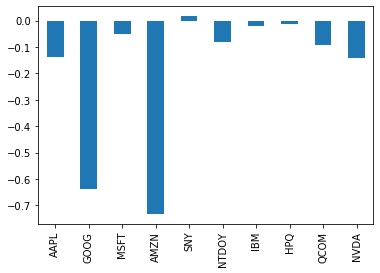

In [144]:
pd.DataFrame(pca.components_, index = ['loadings'], columns = close_df.columns).transpose()['loadings'].plot(kind = 'bar')

In [139]:
import seaborn as sns

<Figure size 1008x432 with 0 Axes>

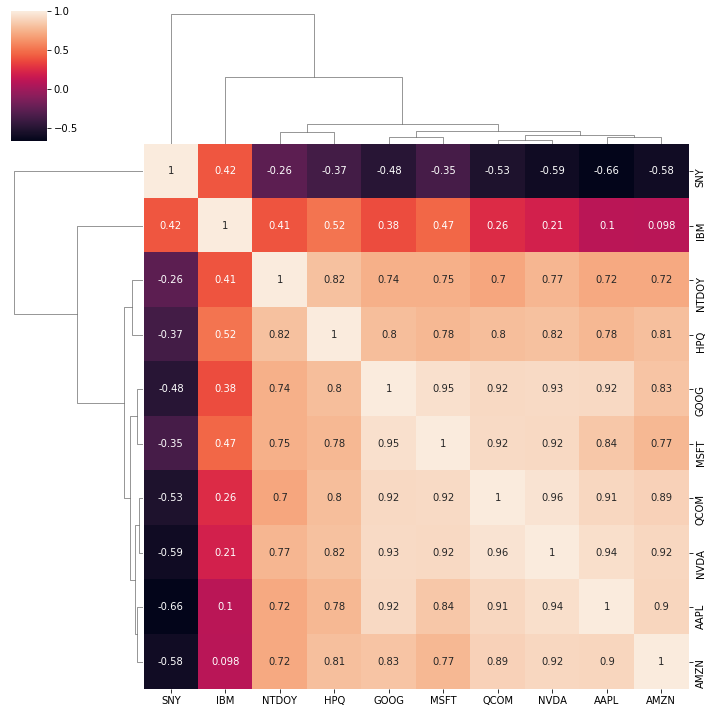

In [146]:
fig = plt.figure(figsize = (14, 6))
g = sns.clustermap(close_df.corr(), annot = True)